# Imports

In [1]:
import dolfin as dl
import hippylib as hl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from spin.core import problem
from spin.fenics import converter
from spin.hippylib import hessian, laplace, misfit, optimization, prior

sns.set_theme(style="ticks")

# PDE Problem and Data

In [2]:
mesh = dl.RectangleMesh(dl.Point(-0.75, -0.75), dl.Point(0.75, 0.75), 50, 50)
problem_settings = problem.SPINProblemSettings(
    mesh=mesh,
    pde_type="mean_exit_time",
    inference_type="drift_only",
    log_squared_diffusion=("std::log(std::pow(x[0],2) + std::pow(x[1],2) + 2)", "std::log(1)"),
)
problem_builder = problem.SPINProblemBuilder(problem_settings)
spin_problem = problem_builder.build()

In [3]:
parameter_coordinates = spin_problem.coordinates_parameters
solution_coordinates = spin_problem.coordinates_variables
true_parameter = converter.create_dolfin_function(
    ("-2*std::pow(x[0]+x[1],3) + 3*x[0] + x[1]", "-x[0]-2*x[1]"),
    spin_problem.function_space_parameters,
)
true_parameter = converter.convert_to_numpy(
    true_parameter.vector(), spin_problem.function_space_parameters
)
true_solution = spin_problem.solve_forward(true_parameter)

In [4]:
noise_std = 0.01
num_data_points = 1000
rng = np.random.default_rng(seed=0)
data_indices = rng.integers(1, true_solution.size - 1, size=num_data_points)
data_locations = solution_coordinates[data_indices, :]
data_values = true_solution[data_indices]
noise = rng.normal(loc=0, scale=noise_std, size=data_values.shape)
data_values = data_values + noise

Text(0, 0.5, 'y')

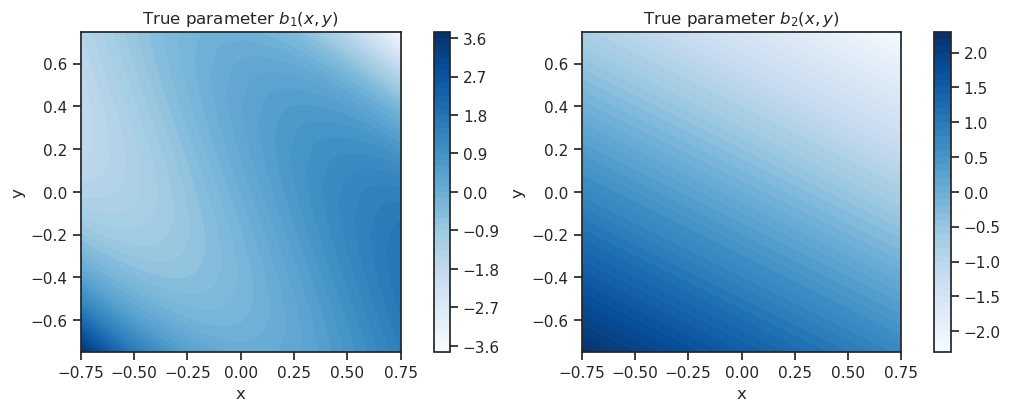

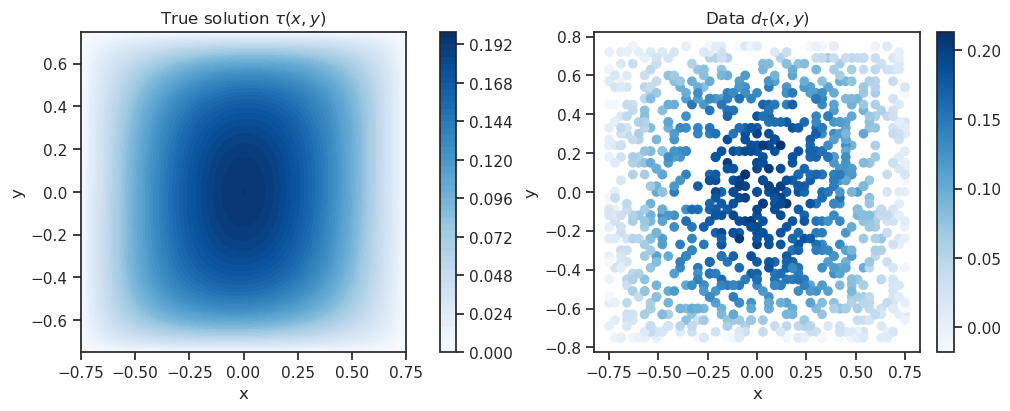

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout="constrained")
contour_plot = axs[0].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    true_parameter[0, :],
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[0].set_title(r"True parameter $b_1(x, y)$")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

contour_plot = axs[1].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    true_parameter[1, :],
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[1].set_title(r"True parameter $b_2(x, y)$")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), layout="constrained")
contour_plot = axs[0].tricontourf(
    solution_coordinates[:, 0],
    solution_coordinates[:, 1],
    true_solution,
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[0].set_title(r"True solution $\tau(x, y)$")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

scatter_plot = axs[1].scatter(
    data_locations[:, 0], data_locations[:, 1], c=data_values, cmap="Blues"
)
fig.colorbar(scatter_plot)
axs[1].set_title(r"Data $d_\tau(x, y)$")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

# Prior

In [31]:
prior_settings = prior.PriorSettings(
    function_space=spin_problem.function_space_parameters,
    mean=("-x[0]", "-x[1]"),
    variance=("1", "1"),
    correlation_length=("0.75", "0.75"),
    robin_bc=True,
    robin_bc_const=1.42,
)
prior_builder = prior.BilaplacianVectorPriorBuilder(prior_settings)
spin_prior = prior_builder.build()
prior_variance = spin_prior.compute_variance_with_boundaries(
    method="Randomized", num_eigenvalues_randomized=500
)

Text(0, 0.5, 'y')

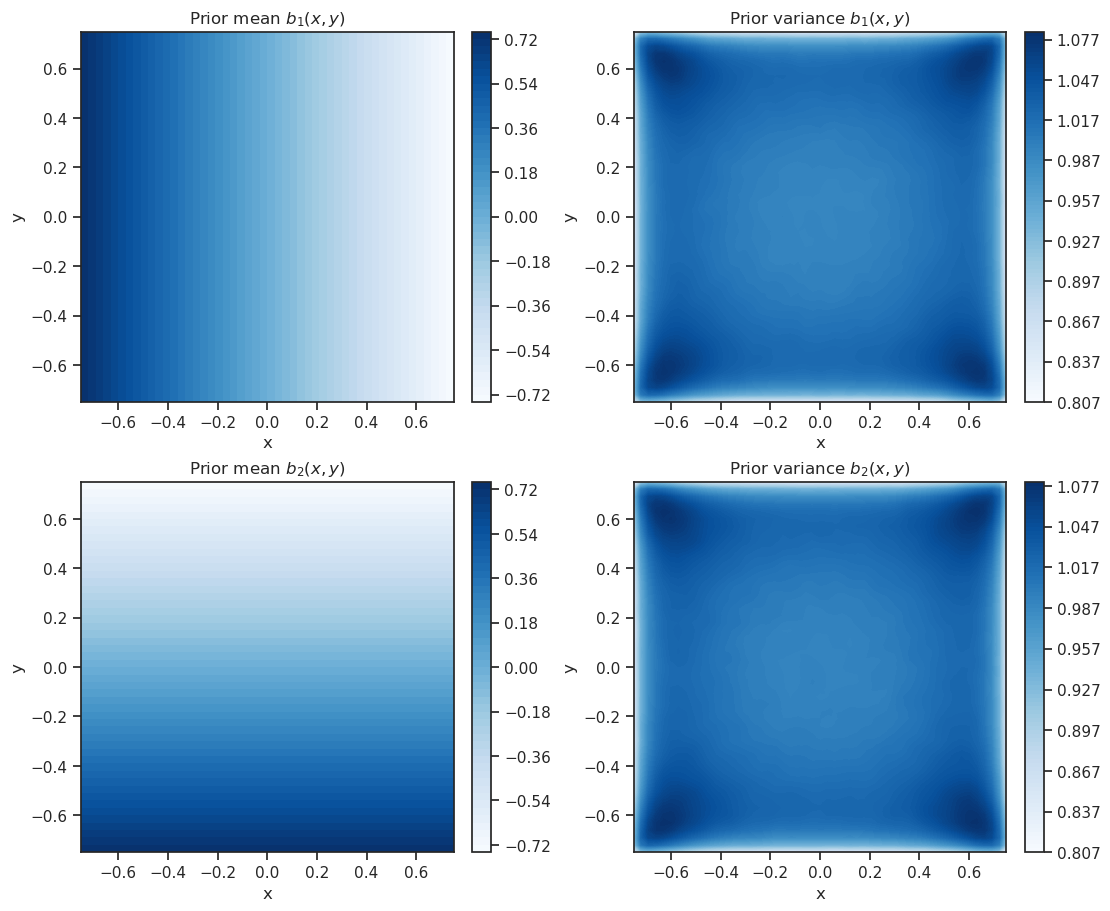

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(11, 9), layout="constrained")
contour_plot = axs[0, 0].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    spin_prior.mean_array[0, :],
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[0, 0].set_title(r"Prior mean $b_1(x,y)$")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")

contour_plot = axs[0, 1].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    prior_variance[0, :],
    levels=100,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[0, 1].set_title(r"Prior variance $b_1(x,y)$")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")

contour_plot = axs[1, 0].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    spin_prior.mean_array[1, :],
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[1, 0].set_title(r"Prior mean $b_2(x,y)$")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")

contour_plot = axs[1, 1].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    prior_variance[1, :],
    levels=100,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[1, 1].set_title(r"Prior variance $b_2(x,y)$")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")

# Misfit and Inference Model

In [34]:
misfit_settings = misfit.MisfitSettings(
    function_space=spin_problem.function_space_variables,
    observation_points=data_locations,
    observation_values=data_values,
    noise_variance=np.ones(data_values.shape) * noise_std**2,
)
misfit_builder = misfit.MisfitBuilder(misfit_settings)
spin_misfit = misfit_builder.build()

In [35]:
inference_model = hl.Model(
    spin_problem.hippylib_variational_problem,
    spin_prior.hippylib_prior,
    spin_misfit.hippylib_misfit,
)

# Optimization

In [36]:
optimization_settings = optimization.SolverSettings(
    relative_tolerance=1e-8, absolute_tolerance=1e-12, verbose=True
)
initial_guess = spin_prior.mean_array
newton_solver = optimization.NewtonCGSolver(optimization_settings, inference_model)
solver_solution = newton_solver.solve(initial_guess)
print("Termination reason:", solver_solution.termination_reason)


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    7.868003e+02    7.857513e+02    1.048988e+00   -3.383259e+03   4.966779e+03   1.000000e+00   5.000000e-01
  2   2    5.170155e+02    5.118995e+02    5.116015e+00   -5.752517e+02   6.788831e+02   1.000000e+00   3.697090e-01
  3   1    4.965933e+02    4.918661e+02    4.727190e+00   -4.088642e+01   4.021309e+02   1.000000e+00   2.845420e-01
  4   8    4.814364e+02    4.725205e+02    8.915829e+00   -3.047805e+01   8.987423e+01   1.000000e+00   1.345179e-01
  5  11    4.810829e+02    4.714761e+02    9.606803e+00   -6.905836e-01   1.499625e+01   1.000000e+00   5.494825e-02
  6  15    4.810816e+02    4.714704e+02    9.611245e+00   -2.394872e-03   7.874359e-01   1.000000e+00   1.259129e-02
  7  19    4.810816e+02    4.714704e+02    9.611242e+00   -1.197729e-07   5.345564e-03   1.000000e+00   1.037431e-03
Termination reason: Norm of the gradient less than tolerance


# Low-Rank Hessian

In [37]:
hessian_settings = hessian.LowRankHessianSettings(
    num_eigenvalues=60,
    num_oversampling=20,
    inference_model=inference_model,
    evaluation_point=[
        solver_solution.forward_solution,
        solver_solution.optimal_parameter,
        solver_solution.adjoint_solution,
    ],
)
eigenvalues, eigenvectors = hessian.compute_low_rank_hessian(hessian_settings)

Text(0, 0.5, '$\\lambda_i$')

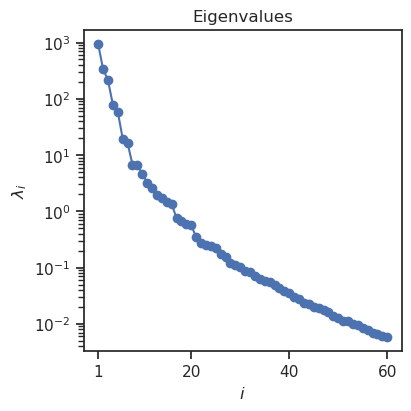

In [38]:
index_vector = np.arange(1, eigenvalues.size + 1)
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.semilogy(index_vector, eigenvalues, marker="o")
ax.set_title("Eigenvalues")
ax.set_xticks((1, 20, 40, 60))
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\lambda_i$")

# Laplace Approximation

In [39]:
laplace_approximation_settings = laplace.LowRankLaplaceApproximationSettings(
    inference_model=inference_model,
    mean=solver_solution.optimal_parameter,
    low_rank_hessian_eigenvalues=eigenvalues,
    low_rank_hessian_eigenvectors=eigenvectors,
)
laplace_approximation = laplace.LowRankLaplaceApproximation(laplace_approximation_settings)
posterior_variance = laplace_approximation.compute_pointwise_variance(
    method="Randomized", num_eigenvalues_randomized=50
)
prior_predictive = spin_problem.solve_forward(spin_prior.mean_array)
posterior_predictive = spin_problem.solve_forward(solver_solution.optimal_parameter)

Text(0, 0.5, 'y')

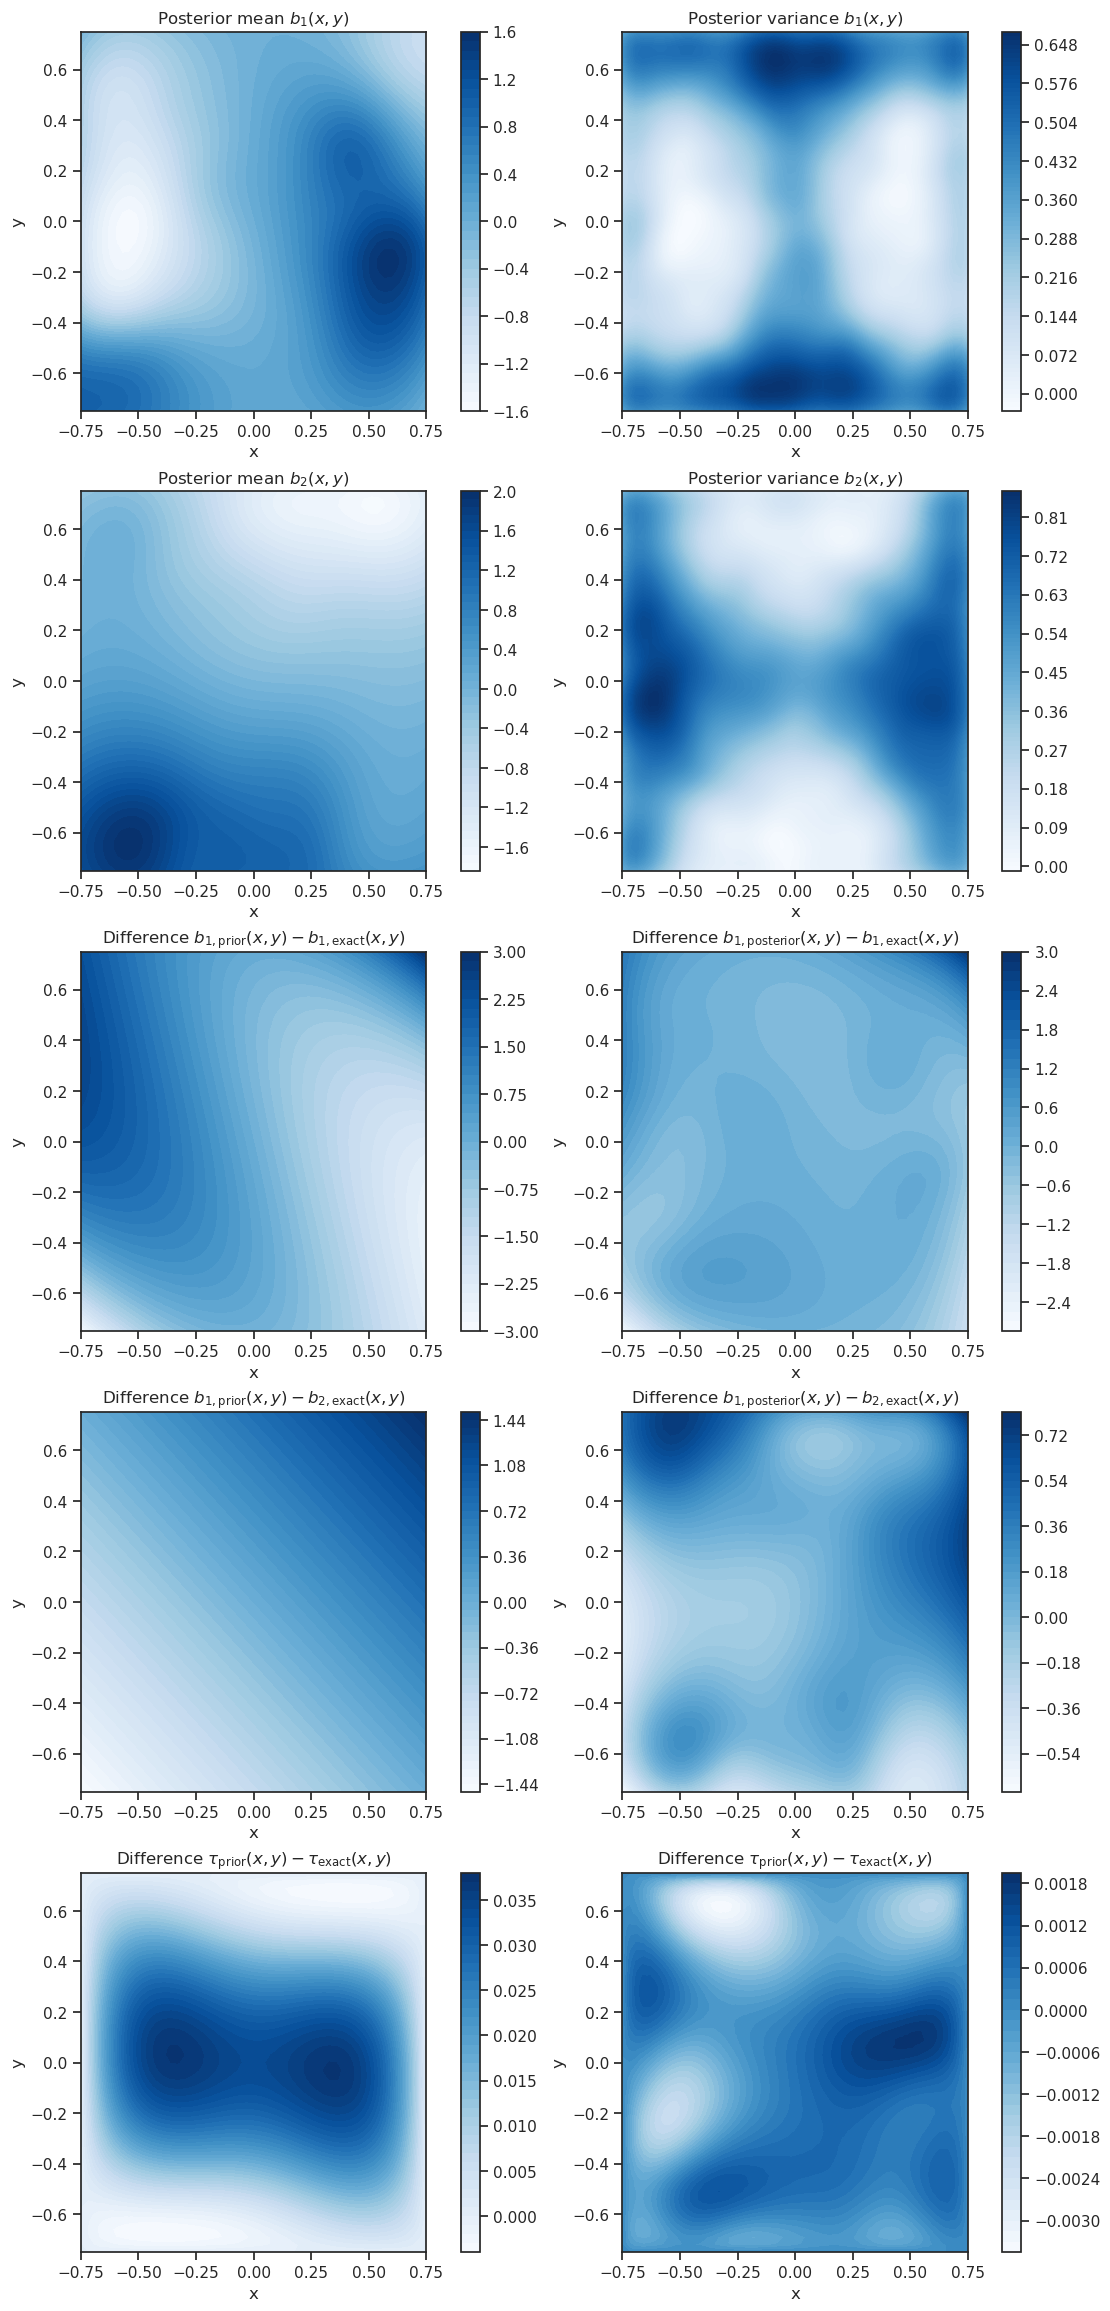

In [40]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(11, 23), layout="constrained")
contour_plot = axs[0, 0].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    solver_solution.optimal_parameter[0, :],
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[0, 0].set_title(r"Posterior mean $b_1(x,y)$")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")

contour_plot = axs[0, 1].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    posterior_variance[0, :],
    levels=100,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[0, 1].set_title(r"Posterior variance $b_1(x,y)$")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")

contour_plot = axs[1, 0].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    solver_solution.optimal_parameter[1, :],
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[1, 0].set_title(r"Posterior mean $b_2(x,y)$")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel("y")

contour_plot = axs[1, 1].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    posterior_variance[1, :],
    levels=100,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[1, 1].set_title(r"Posterior variance $b_2(x,y)$")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")

contour_plot = axs[2, 0].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    spin_prior.mean_array[0, :] - true_parameter[0, :],
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[2, 0].set_title(r"Difference $b_{1,\text{prior}}(x,y) - b_{1,\text{exact}}(x,y)$")
axs[2, 0].set_xlabel("x")
axs[2, 0].set_ylabel("y")

contour_plot = axs[2, 1].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    solver_solution.optimal_parameter[0, :] - true_parameter[0, :],
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[2, 1].set_title(r"Difference $b_{1,\text{posterior}}(x,y) - b_{1,\text{exact}}(x,y)$")
axs[2, 1].set_xlabel("x")
axs[2, 1].set_ylabel("y")

contour_plot = axs[3, 0].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    spin_prior.mean_array[1, :] - true_parameter[1, :],
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[3, 0].set_title(r"Difference $b_{1,\text{prior}}(x,y) - b_{2,\text{exact}}(x,y)$")
axs[3, 0].set_xlabel("x")
axs[3, 0].set_ylabel("y")

contour_plot = axs[3, 1].tricontourf(
    parameter_coordinates[:, 0],
    parameter_coordinates[:, 1],
    solver_solution.optimal_parameter[1, :] - true_parameter[1, :],
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[3, 1].set_title(r"Difference $b_{1,\text{posterior}}(x,y) - b_{2,\text{exact}}(x,y)$")
axs[3, 1].set_xlabel("x")
axs[3, 1].set_ylabel("y")

contour_plot = axs[4, 0].tricontourf(
    solution_coordinates[:, 0],
    solution_coordinates[:, 1],
    prior_predictive - true_solution,
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[4, 0].set_title(r"Difference $\tau_{\text{prior}}(x,y) - \tau_{\text{exact}}(x,y)$")
axs[4, 0].set_xlabel("x")
axs[4, 0].set_ylabel("y")

contour_plot = axs[4, 1].tricontourf(
    solution_coordinates[:, 0],
    solution_coordinates[:, 1],
    posterior_predictive - true_solution,
    levels=50,
    cmap="Blues",
)
fig.colorbar(contour_plot)
axs[4, 1].set_title(r"Difference $\tau_{\text{prior}}(x,y) - \tau_{\text{exact}}(x,y)$")
axs[4, 1].set_xlabel("x")
axs[4, 1].set_ylabel("y")